<a href="https://colab.research.google.com/github/wisdomsy/wisdomsy-project/blob/main/8%EA%B8%B0_%EB%B0%A9%EC%A4%91_%EC%B6%95%EA%B5%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 수집

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import re
from google.colab import files

header_info = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"
}

In [ ]:
'''
자책골 이벤트 수집. OG in text: 자책골
슈팅 이벤트 수집.
OG 데이터 (시간) 삽입 후 시간 순으로 정렬. 근데 45+2 같은게 있으니 텍스트로 정렬
'''

'\n자책골 이벤트 수집. OG in text: 자책골\n슈팅 이벤트 수집.\nOG 데이터 (시간) 삽입 후 시간 순으로 정렬. 근데 45+2 같은게 있으니 텍스트로 정렬\n'

In [ ]:
def sort_time(time):
  if '+' in time:
    base, extra = time.split('+')
    return int(base), int(extra)
  else:
    return int(time), 0

In [ ]:
columns = ['고유 코드', 'League', 'Season', 'Home', 'Away', 'Player', 'Team', 'at time', '+-', 'xG', 'Goal', 'isOwn']
data_final = {column:[] for column in columns}

In [ ]:
leagues = leagues = {'Premier-League':'9'} # , 'Champions-League':'8'
seasons_epl = ['2024-2025', '2023-2024', '2022-2023', '2021-2022', '2020-2021'] # '2024-2025', '2023-2024' , 22-23은 197
seasons_ucl = ['2017-2018', '2016-2017', '2015-2016', '2014-2015', '2013-2014']

for league in leagues:
  if league == 'Premier-League':
    seasons = seasons_epl
  else:
    seasons = seasons_ucl
  for season in seasons:
    ## 데이터 생성
    data_final = {column:[] for column in columns}

    ## 링크 생성
    url = 'https://fbref.com/en/comps/' + leagues[league] + '/'+ season + '/schedule/' + season + '-' + league + '-Scores-and-Fixtures'

    ## 각 시즌 데이터에서 경기 매치 리포트 링크 크롤링
    page = requests.get(url, headers = header_info)
    page = page.text
    soup = BeautifulSoup(page, 'html.parser')
    links = [a['href'] for td in soup.find_all('td', {'data-stat': 'match_report'}) if (a := td.find('a'))]

    if season == '2024-2025': links = links[:200] # 이번 시즌은 19R까지만 수집.
    elif season == '2022-2023': links = links[197:]

    ## 각 경기의 세부 데이터 크롤링
    num = 0
    print(league, season) # 진행 사항 확인 용
    time.sleep(6)

    for link in links:
      ### 링크 생성
      url = 'https://fbref.com/' + link
      page = requests.get(url, headers = header_info)
      page = page.text
      soup = BeautifulSoup(page, 'html.parser')

      ### 홈 팀 및 원정 팀 이름
      team = soup.find_all('h2') # 경기 조사
      home = ' '.join(team[2].text.split(' ')[0:-2]) # 홈팀
      away = ' '.join(team[9].text.split(' ')[0:-2]) # 원정팀

      ### 자책골 이벤트
      event_home = soup.find_all("div", class_="event", id="a") # 홈팀
      home_own = []
      for event in event_home:
        if 'OG' in event.text:
          match = re.search(r'\d+\+?\d*', event.text)
          if match:
            home_own.append(match.group())

      event_away = soup.find_all("div", class_="event", id="b") # 원정팀
      away_own = []
      for event in event_away:
        if 'OG' in event.text:
          match = re.search(r'\d+\+?\d*', event.text)
          if match:
            away_own.append(match.group())

      ### 슈팅 이벤트
      tables = soup.find_all('table', id = "shots_all")
      shots = tables[0]

      data = []
      headers = [header.text for header in shots.find_all('th')][3:16]

      for row in shots.find_all('tr')[2:]:  # 첫 번째 행은 헤더라서 제외
        if row.find_all('th')[0].text != '':
          row_data = [row.find_all('th')[0].text]
          cells = row.find_all('td')
          for cell in cells:
            row_data.append(cell.text)
          data.append(row_data)

      df_raw = pd.DataFrame(data, columns=headers) # 슈팅 데이터
      df_raw = df_raw.iloc[:, [0, 1, 2, 3, 5]] # Minute, Player, Squad, xG, Outcome 열 추출

      for i in range(len(home_own)):
        df_raw.loc[len(df_raw)] = [home_own[i], '', away, 'NA', 'Own Goal']

      for i in range(len(away_own)):
        df_raw.loc[len(df_raw)] = [away_own[i], '', home, 'NA', 'Own Goal']

      df_raw.loc[:, 'sort'] = df_raw['Minute'].apply(sort_time)
      df_raw = df_raw.sort_values(by='sort', ascending=True, kind='stable').drop(columns='sort').reset_index(drop=True)

      ### 데이터 추출
      score_home = 0
      score_away = 0
      for i in range(len(df_raw)):
        # 슈팅 시점 골득실 계산
        if home == df_raw.loc[i, 'Squad'][1:]:
          data_final['+-'].append(score_home - score_away)
        else:
          data_final['+-'].append(score_away - score_home)

        # 데이터 저장
        data_final['고유 코드'].append(link.split('/')[3])
        data_final['League'].append(league)
        data_final['Season'].append(season)
        data_final['Home'].append(home)
        data_final['Away'].append(away)
        data_final['Player'].append(df_raw.loc[i, 'Player'])
        data_final['Team'].append(df_raw.loc[i, 'Squad'][1:])
        data_final['at time'].append(df_raw.loc[i, 'Minute'])
        data_final['xG'].append(df_raw.loc[i, 'xG'])

        # 득점 및 자책골 처리
        if df_raw.loc[i, 'Outcome'] == 'Goal': # 득점인 경우
          data_final['Goal'].append(1)
          data_final['isOwn'].append(0)
          if home == df_raw.loc[i, 'Squad'][1:]:
            score_home += 1
          else:
            score_away += 1
        elif df_raw.loc[i, 'Outcome'] == 'Own Goal': # 자책골인 경우
          data_final['isOwn'].append(1)
          data_final['Goal'].append(0)
          if home == df_raw.loc[i, 'Squad'][1:]:
            score_away += 1
          else:
            score_home += 1
        else: # 나머지 경우
          data_final['Goal'].append(0)
          data_final['isOwn'].append(0)

      # 진행 사항 확인 용
      print(num, end=' ')
      num += 1
      if num % 50 == 0:
        print()
      time.sleep(6.5)

    df_final = pd.DataFrame(data_final)
    df_final.to_excel(league+'_'+season+'.xlsx', index=False)
    files.download(league+'_'+season+'.xlsx')

Premier-League 2022-2023
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 
150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Premier-League 2021-2022
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 
150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 
250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Premier-League 2020-2021
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 
150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 
250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_final = pd.DataFrame(data_final)
df_final

,고유 코드,League,Season,Home,Away,Player,Team,at time,+-,xG,Goal,isOwn
0,e62f6e78,Premier-League,2022-2023,Crystal Palace,Arsenal,Gabriel Jesus,Arsenal,4,0,0.15,0,0
1,e62f6e78,Premier-League,2022-2023,Crystal Palace,Arsenal,Gabriel Martinelli,Arsenal,4,0,0.22,0,0
2,e62f6e78,Premier-League,2022-2023,Crystal Palace,Arsenal,Oleksandr Zinchenko,Arsenal,8,0,0.03,0,0
3,e62f6e78,Premier-League,2022-2023,Crystal Palace,Arsenal,Thomas Partey,Arsenal,9,0,0.10,0,0
4,e62f6e78,Premier-League,2022-2023,Crystal Palace,Arsenal,Gabriel Martinelli,Arsenal,20,0,0.16,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4957,1b35bc71,Premier-League,2022-2023,Arsenal,Manchester Utd,Gabriel Martinelli,Arsenal,81,0,0.06,0,0
4958,1b35bc71,Premier-League,2022-2023,Arsenal,Manchester Utd,Eddie Nketiah,Arsenal,84,0,0.47,0,0
4959,1b35bc71,Premier-League,2022-2023,Arsenal,Manchester Utd,Christian Eriksen,Manchester Utd,87,0,0.06,0,0
4960,1b35bc71,Premier-League,2022-2023,Arsenal,Manchester Utd,Martin Ødegaard,Arsenal,90,0,0.09,0,0


In [ ]:
df_final.to_excel(league+'_'+season+'.xlsx', index=False)
files.download(league+'_'+season+'.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 데이터 전처리

In [ ]:
def calculate_time_intervals_with_first(group):
    intervals = []
    for i in range(len(group)):
        if i == 0:
            # 첫 득점은 득점 시간 자체를 간격으로 설정
            interval = group.iloc[i]['time'] + group.iloc[i]['extra']
        else:
            prev = group.iloc[i - 1]
            curr = group.iloc[i]
            if (prev['time'] <= 45 and curr['time'] <= 45) or (prev['time'] > 45 and curr['time'] > 45):
                # 같은 하프타임
                interval = (curr['time'] - prev['time']) + (curr['extra'] - prev['extra'])
            else:
                # 다른 하프타임
                interval = (curr['time'] - prev['time']) + curr['extra']
        intervals.append(interval)
    return pd.Series(intervals, index=group.index)

In [ ]:
# 득점 통합 및 시간 전처리
pl_2324 = pd.read_excel('Premier-League_2023-2024.xlsx')
pl_2324['Total_Score'] = pl_2324['Goal'] + pl_2324['isOwn']
pl_2324['time'] = pl_2324['at time'].apply(lambda x: int(x.split('+')[0]))
pl_2324['extra'] = pl_2324['at time'].apply(lambda x: int(x.split('+')[1]) if '+' in x else 0)

# 2. 'Half' 열 추가 (전반: 1, 후반: 2)
pl_2324['Half'] = pl_2324['time'].apply(lambda x: 1 if x <= 45 else 2)

# 3. 각 경기별 전반/후반 최대 추가시간 계산
extra_time_by_match = pl_2324.groupby(['고유 코드', 'Half'])['extra'].max().unstack(fill_value=0)
extra_time_by_match.columns = ['Min_1H_Extra', 'Min_2H_Extra']

# 4. 원본 데이터와 병합
pl_2324 = pl_2324.merge(extra_time_by_match, on='고유 코드', how='left')

# 5. NaN 값 처리
pl_2324['Min_1H_Extra'] = pl_2324['Min_1H_Extra'].fillna(0).astype(int)
pl_2324['Min_2H_Extra'] = pl_2324['Min_2H_Extra'].fillna(0).astype(int)

# 6. 잔여 시간 계산
def calculate_remaining_time_v2(time, half, min_extra_1H, min_extra_2H, extra):
    if half == 1:  # 전반
        return (45 - time) + min_extra_1H - extra + 45 + min_extra_2H
    else:  # 후반
        return (90 - time) + min_extra_2H - extra

pl_2324['Remaining_Time'] = pl_2324.apply(lambda row: calculate_remaining_time_v2(
    row['time'], row['Half'], row['Min_1H_Extra'], row['Min_2H_Extra'], row['extra']
), axis=1)

# 득점 간격 구하기
# df_scores = pl_2324[pl_2324['Total_Score'] == 1]

# 각 경기별로 득점 간격 계산
# df_scores['time_interval'] = df_scores.groupby('고유 코드').apply(calculate_time_intervals_with_first).reset_index(level=0, drop=True)

# 데이터 분석

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare

## 푸아송 분포 검정

In [ ]:
# 고유 코드별로 Goal과 isOwn의 합을 구해서 각 경기의 득점 합 계산
grouped_scores = df_2024.groupby(['고유 코드'])[['Total_Score']].sum()

np.mean(grouped_scores['Total_Score'])

<ipython-input-160-8533defb6ed1>:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  poisson_values = [(mean_goals ** k) * np.exp(-mean_goals) / np.math.factorial(k) * len(score_distribution) for k in x_values]


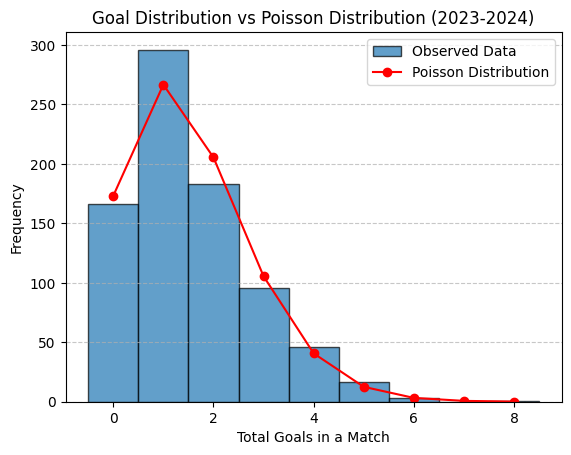

mean: 1.5408415841584158, variance: 1.6171438461915482
Chi-squared Statistic: 14.597546579839705
P-value: 0.041518573091876905


<ipython-input-160-8533defb6ed1>:26: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  poisson_probs = [((mean_goals ** k) * np.exp(-mean_goals)) / np.math.factorial(k) for k in observed_frequencies.index]


In [ ]:
# 고유 코드별로 Goal과 isOwn의 합을 구해서 각 경기의 득점 합 계산
grouped_scores = df_2024.groupby(['고유 코드', 'Team'])[['Total_Score']].sum()

# 득점 합 분포 확인
score_distribution = grouped_scores['Total_Score']

# 실제 푸아송 분포 데이터와 히스토그램 비교
x_values = np.arange(0, score_distribution.max() + 1)
poisson_values = [(mean_goals ** k) * np.exp(-mean_goals) / np.math.factorial(k) * len(score_distribution) for k in x_values]

# 히스토그램과 푸아송 분포 곡선 그리기
plt.hist(score_distribution, bins=range(0, score_distribution.max() + 2), edgecolor='black', align='left', alpha=0.7, label='Observed Data')
plt.plot(x_values, poisson_values, marker='o', linestyle='-', color='red', label='Poisson Distribution')
plt.title('Goal Distribution vs Poisson Distribution (2023-2024)')
plt.xlabel('Total Goals in a Match')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 득점 분포 데이터
observed_frequencies = score_distribution.value_counts().sort_index()

# 푸아송 분포 근사 (평균 계산)
mean_goals = score_distribution.mean()
poisson_probs = [((mean_goals ** k) * np.exp(-mean_goals)) / np.math.factorial(k) for k in observed_frequencies.index]
expected_frequencies = [p * len(score_distribution) for p in poisson_probs]

# 관측 빈도와 기대 빈도의 합 정규화
observed_frequencies_sum = observed_frequencies.sum()
expected_frequencies_sum = sum(expected_frequencies)
scaling_factor = observed_frequencies_sum / expected_frequencies_sum
normalized_expected_frequencies = [freq * scaling_factor for freq in expected_frequencies]

# 카이제곱 검정
chi2_stat, p_value = chisquare(f_obs=observed_frequencies, f_exp=normalized_expected_frequencies)

# 결과 출력
print(f"mean: {np.mean(grouped_scores['Total_Score'])}, variance: {np.var(grouped_scores['Total_Score'])}")
print(f"Chi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")

## 지수 분포 검정

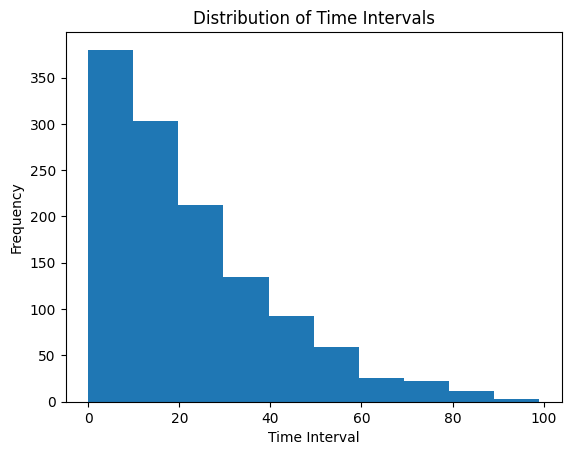

mean: 22.398393574297188, variance: 350.41317011016145


In [ ]:
plt.hist(df_scores['time_interval'], bins=10)
plt.xlabel('Time Interval')
plt.ylabel('Frequency')
plt.title('Distribution of Time Intervals')
plt.show()

print(f"mean: {np.mean(df_scores['time_interval'])}, variance: {np.var(df_scores['time_interval'])}")

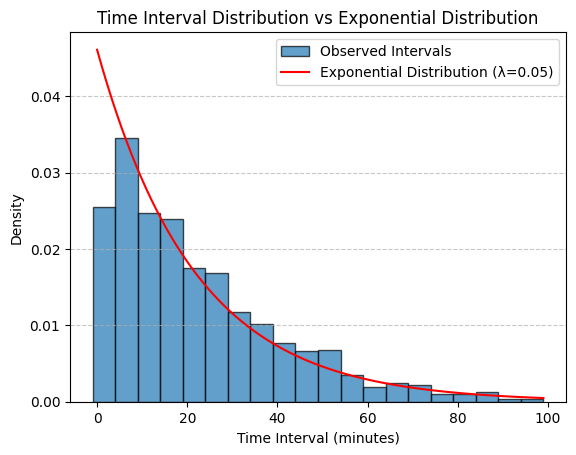

(19.710212676046716, 0.01978747283407992)

In [ ]:
from scipy.stats import expon

# 득점 간 시간 간격 데이터에서 유효한 값만 추출
valid_intervals = df_scores['time_interval'].dropna()

# 히스토그램 데이터 계산
hist_data, bin_edges = np.histogram(valid_intervals, bins=20, density=True)

# 지수 분포 파라미터 (λ) 추정 (평균의 역수)
lambda_estimate = 1 / valid_intervals.mean()

# 지수 분포 함수 계산
x_values = np.linspace(0, valid_intervals.max(), 1000)
exponential_values = lambda_estimate * np.exp(-lambda_estimate * x_values)

# 히스토그램과 지수 분포 그래프 그리기
plt.hist(valid_intervals, bins=20, density=True, alpha=0.7, edgecolor='black', label='Observed Intervals')
plt.plot(x_values, exponential_values, color='red', label='Exponential Distribution (λ={:.2f})'.format(lambda_estimate))
plt.title('Time Interval Distribution vs Exponential Distribution')
plt.xlabel('Time Interval (minutes)')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 관측 빈도 계산 (히스토그램)
observed_frequencies, bin_edges = np.histogram(valid_intervals, bins=10, density=False)

# 기대 빈도 계산 (지수 분포 기반)
bin_widths = np.diff(bin_edges)
expected_frequencies = [
    len(valid_intervals) * (expon.cdf(bin_edges[i + 1], scale=1 / lambda_estimate) -
                            expon.cdf(bin_edges[i], scale=1 / lambda_estimate))
    for i in range(len(bin_edges) - 1)
]

# 관측 빈도와 기대 빈도의 총합 확인
observed_sum = sum(observed_frequencies)
expected_sum = sum(expected_frequencies)

# 정규화된 기대 빈도 계산
normalized_expected_frequencies = [freq * (observed_sum / expected_sum) for freq in expected_frequencies]

# 카이제곱 검정 재실행
chi2_stat, p_value = chisquare(f_obs=observed_frequencies, f_exp=normalized_expected_frequencies)
chi2_stat, p_value

## 지표 제작

In [ ]:
import pandas as pd
from google.colab import files
from scipy.stats import poisson

In [ ]:
# 잔여 시간 계산
def calculate_remaining_time_v2(time, half, min_extra_1H, min_extra_2H, extra):
    if half == 1:  # 전반
        return (45 - time) + min_extra_1H - extra + 45 + min_extra_2H
    else:  # 후반
        return (90 - time) + min_extra_2H - extra

# 기대 승률 계산
def calculate_win_probability_global(current_goal_diff, remaining_time, avg_goals_per_game):
    """
    현재 득실차와 남은 시간을 바탕으로, 리그 전체 평균 득점을 사용하여 기대 승률을 계산한다.

    Parameters:
        current_goal_diff (int): 현재 득실차 (양수: 리드, 0: 동점, 음수: 지고 있음)
        remaining_time (int): 남은 경기 시간 (분)
        avg_goals_per_game (float): 리그 전체 평균 경기당 득점

    Returns:
        dict: 승률, 무승부 확률, 패배 확률
    """
    # 남은 시간 동안 각 팀의 예상 득점 (λ 변환)
    lambda_team_adj = (avg_goals_per_game / 2) * (remaining_time / 90)
    lambda_opponent_adj = (avg_goals_per_game / 2) * (remaining_time / 90)

    # 각 팀의 예상 추가 득점에 대한 푸아송 확률 계산
    max_goals = 10  # 최대 고려할 추가 골 수 (실용적인 제한)
    win_prob = 0
    draw_prob = 0
    loss_prob = 0

    for team_goals in range(max_goals):
        for opponent_goals in range(max_goals):
            # 푸아송 확률 계산
            prob_team = poisson.pmf(team_goals, lambda_team_adj)
            prob_opponent = poisson.pmf(opponent_goals, lambda_opponent_adj)
            joint_prob = prob_team * prob_opponent  # 독립적 사건 가정

            # 최종 득점차에 따른 승패 계산
            final_goal_diff = current_goal_diff + team_goals - opponent_goals

            if final_goal_diff > 0:
                win_prob += joint_prob
            elif final_goal_diff == 0:
                draw_prob += joint_prob
            else:
                loss_prob += joint_prob

    return {
        "Win Probability": win_prob,
        "Draw Probability": draw_prob,
        "Loss Probability": loss_prob
    }

# 기대 승점 계산
def expected_points(win_prob, draw_prob, loss_prob):
    """
    기대 승점을 계산한다.
    승리는 3점, 무승부는 1점, 패배는 0점으로 계산.

    Parameters:
        win_prob (float): 승리 확률
        draw_prob (float): 무승부 확률
        loss_prob (float): 패배 확률

    Returns:
        float: 기대 승점
    """
    return (3 * win_prob) + (1 * draw_prob) + (0 * loss_prob)

# 현재 경기 상황 (득점 전후)에서 기대 승점 변화 계산
def expected_points_change(current_goal_diff, remaining_time, avg_goals_per_game):
    """
    득점 전후의 기대 승점 변화량을 계산한다.

    Parameters:
        current_goal_diff (int): 현재 득실차
        remaining_time (int): 남은 시간 (분)
        avg_goals_per_game (float): 리그 전체 평균 경기당 득점

    Returns:
        dict: 득점 전후의 기대 승점과 변화량
    """
    # 득점 전 기대 승률
    prob_before = calculate_win_probability_global(current_goal_diff, remaining_time, avg_goals_per_game)
    exp_points_before = expected_points(prob_before["Win Probability"], prob_before["Draw Probability"], prob_before["Loss Probability"])

    # 득점 후 기대 승률 (득실차 +1)
    prob_after = calculate_win_probability_global(current_goal_diff + 1, remaining_time, avg_goals_per_game)
    exp_points_after = expected_points(prob_after["Win Probability"], prob_after["Draw Probability"], prob_after["Loss Probability"])

    # 기대 승점 변화량
    exp_points_change = exp_points_after - exp_points_before

    return {
        "Expected Points Before Goal": exp_points_before,
        "Expected Points After Goal": exp_points_after,
        "Expected Points Change": exp_points_change
    }

# 실질 클러치 계수 계산
def calculate_clutch_score(current_goal_diff, remaining_time, avg_goals_per_game, actual_goal, xG):
    """
    xG 기반 기대 승점 변화량과 실제 기대 승점 변화량을 비교하여 Clutch Score를 계산한다.

    Parameters:
        current_goal_diff (int): 현재 득실차
        remaining_time (int): 남은 시간 (분)
        avg_goals_per_game (float): 리그 전체 평균 경기당 득점
        actual_goal (bool): 실제로 득점했는지 여부 (True = 득점, False = 득점 실패)
        xG (float): 해당 슈팅의 기대 득점 확률 (Expected Goals)

    Returns:
        dict: 기대 승점 변화량, xG 기반 기대 승점 변화량, Clutch Score
    """
    # 득점 시 기대 승점 변화량 계산
    exp_points_change_if_scored = expected_points_change(current_goal_diff, remaining_time, avg_goals_per_game)["Expected Points Change"]

    # xG 기반 평균 기대 승점 변화량
    exp_xPts_change = xG * exp_points_change_if_scored  # 득점 실패 시 변화 없음

    # 실제 기대 승점 변화량 (득점했으면 반영, 실패했으면 0)
    actual_xPts_change = exp_points_change_if_scored if actual_goal else 0

    # Clutch Score 계산
    clutch_score = actual_xPts_change - exp_xPts_change

    return {
        "Expected Points Change (Actual)": actual_xPts_change,
        "Expected Points Change (xG-based)": exp_xPts_change,
        "Clutch Score": clutch_score
    }

In [ ]:
# 잔여 시간 계산
def calculate_remaining_time_v2(time, half, min_extra_1H, min_extra_2H, extra):
  if half == 1:  # 전반
    return (45 - time) + min_extra_1H - extra + 45 + min_extra_2H
  else:  # 후반
    return (90 - time) + min_extra_2H - extra

In [ ]:
seasons = ['2024-2025', '2023-2024', '2022-2023', '2021-2022', '2020-2021']
for season in seasons:
  print(season)

  df = pd.read_excel('Premier-League_'+season+'.xlsx')
  df['Shot'] = 1
  df['Total_Score'] = df['Goal'] + df['isOwn']
  df['time'] = df['at time'].apply(lambda x: int(x.split('+')[0]))
  df['extra'] = df['at time'].apply(lambda x: int(x.split('+')[1]) if '+' in x else 0)

  # 2. 'Half' 열 추가 (전반: 1, 후반: 2)
  df['Half'] = df['time'].apply(lambda x: 1 if x <= 45 else 2)

  # 3. 각 경기별 전반/후반 최대 추가시간 계산
  extra_time_by_match = df.groupby(['고유 코드', 'Half'])['extra'].max().unstack(fill_value=0)
  extra_time_by_match.columns = ['Min_1H_Extra', 'Min_2H_Extra']

  # 4. 원본 데이터와 병합
  df = df.merge(extra_time_by_match, on='고유 코드', how='left')

  # 5. NaN 값 처리
  df['Min_1H_Extra'] = df['Min_1H_Extra'].fillna(0).astype(int)
  df['Min_2H_Extra'] = df['Min_2H_Extra'].fillna(0).astype(int)

  # 6. 잔여 시간 계산
  df['Remaining_Time'] = df.apply(lambda row: calculate_remaining_time_v2(
      row['time'], row['Half'], row['Min_1H_Extra'], row['Min_2H_Extra'], row['extra']
  ), axis=1)

  # 전체 경기당 평균 득점 계산
  total_goals = df['Total_Score'].sum()
  total_matches = len(df['고유 코드'].unique())  # 고유 경기 수
  avg_goals_per_game = total_goals / total_matches

  # 클러치 지표 계산
  df['xPTS Change'] = df.apply(lambda row: expected_points_change(row['+-'], row['Remaining_Time'], avg_goals_per_game)['Expected Points Change'] if row['Goal'] == 1 else 0, axis=1)
  df['Clutch Score'] = df.apply(lambda row: calculate_clutch_score(row['+-'], row['Remaining_Time'], avg_goals_per_game, row['Goal'], row['xG'])['Clutch Score'], axis=1)

  # 자책골 데이터 제거 및 자책골 열 제거
  if 'isOwn' in df.columns:
    df = df[df['isOwn'] == 0].drop(columns=['isOwn'])

  # 선수별 xPTS Change와 Clutch Score 총합 계산
  player_stats = df.groupby('Player')[['Goal', 'Shot', 'xPTS Change', 'Clutch Score']].sum().reset_index()

  # xPTS Change 내림차순 정렬
  player_stats_sorted = player_stats.sort_values(by='xPTS Change', ascending=False).reset_index(drop=True)
  player_stats_sorted.to_excel('Premier-League_'+season+'_player_stats.xlsx', index=False)
  files.download('Premier-League_'+season+'_player_stats.xlsx')

## 자기상관성 확인

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

In [ ]:

# 파일 경로
file_paths = {
    "2020-2021": "Premier-League_2020-2021_player_stats.xlsx",
    "2021-2022": "Premier-League_2021-2022_player_stats.xlsx",
    "2022-2023": "Premier-League_2022-2023_player_stats.xlsx",
    "2023-2024": "Premier-League_2023-2024_player_stats.xlsx",
    "2024-2025": "Premier-League_2024-2025_player_stats.xlsx"
}

# 데이터 로드
season_data = {}
for season, path in file_paths.items():
    df = pd.read_excel(path)
    season_data[season] = df

# 데이터 필터링 (슈팅 30개 이상)
for season in season_data:
    season_data[season] = season_data[season][season_data[season]['Shot'] >= 30]

# 연속 시즌 데이터 결합
columns = ['xPTS Change pre', 'xPTS Change post', 'Clutch Score pre', 'Clutch Score post']
merged_data = pd.DataFrame(columns=columns)

seasons = list(season_data.keys())

for i in range(len(seasons) - 1):
    season_pre = seasons[i]
    season_post = seasons[i + 1]

    df_pre = season_data[season_pre][['Goal', 'Shot', 'xPST Change', 'Clutch Score']]
    df_post = season_data[season_post][['Goal', 'Shot', 'xPST Change', 'Clutch Score']]

    df_pre = df_pre.rename(columns={'xPST Change': 'xPTS Change pre', 'Clutch Score': 'Clutch Score pre'})
    df_post = df_post.rename(columns={'xPST Change': 'xPTS Change post', 'Clutch Score': 'Clutch Score post'})

    merged = df_pre.merge(df_post, on='Player', how='inner')

    merged_data = pd.concat([merged_data, merged[columns]], ignore_index=True)

# 상관관계 분석
correlation_matrix = merged_data.corr()

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Pre and Post Performance Metrics")
plt.show()